
# Notebook for training and testing YOLTv4

#### _Author: Adam Van Etten - February 2021_

This notebook is assumed to be running in the yoltv4 conda environment.   Below, we provide examples of how to use this repository with the open-source [Rareplanes](https://registry.opendata.aws/rareplanes/) dataset. 


In [1]:
from shapely.affinity import translate
from shapely.geometry import box
import matplotlib.pyplot as plt
from shapely.wkt import loads
from imp import reload
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import numpy as np
import collections
import skimage.io
import shapely
import random
import shutil
import imp
import cv2
import sys
import os

yoltv4_path = '/vol/bitbucket/jrb21/project/YOLO/yoltv4'
sys.path.append(os.path.join(yoltv4_path, 'yoltv4'))
import prep_train
import tile_ims_labels
import post_process
reload(prep_train)

# set dataset path
data_root = '/vol/bitbucket/jrb21/project/xView/data'

/tmp/ipykernel_1041958/923330721.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


------
## 1. Training Preparation

------
We assume that images are large .tif files, with one label for each image.  Labels can be .geojsons, or a .csv.  Either way, the labels are assumed to be in pixel coordinates (see [solaris](https://github.com/CosmiQ/solaris) for tools to convert geographic coordinates to pixel coordinates.  Further labels are assumed to have a minimum of the following columns:

    'geometry', 'category', image_name'
    
We want the labels in the form of a geodataframe, which can be loaded via:
    
    gdf_pix = gpd.read_file(path_to_labels)

#### Read in file and convert bbx coords into geometry objects

In [2]:
xView = gpd.read_file('/vol/bitbucket/jrb21/project/xView/data/xView_train.geojson')

In [3]:
def polygon(string):
    xmin, ymin, xmax, ymax = [int(x) for x in string.split(",")]
    square = shapely.geometry.Polygon([(xmin,ymin), (xmax,ymin), (xmax,ymax), (xmin, ymax)])
    return square
    

In [4]:
xView['pixel_coords'] = xView['bounds_imcoords'].apply(polygon)

#### Read in label definitons

In [5]:
labels = pd.read_csv('/vol/bitbucket/jrb21/project/xView/data/xview_class_labels.txt', sep = ":", 
                     header = None, index_col =0, names = ['id','class'])

HGVs = ["Truck",
        "Truck Tractor w/ Box Trailer",
        "Truck Tractor",
        "Truck Tractor w/ Flatbed Trailer",
        "Crane Truck",
        "Truck Tractor w/ Liquid Tank"]

truck_df = xView[xView['type_id'].isin(labels[labels["class"].isin(HGVs)].index)]
gdf_pix = truck_df

In [6]:
gdf_pix[['bounds_imcoords', 'pixel_coords', 'type_id', 'image_id']].head()

bounds_imcoords                                       pixel_coords  \
82     1376,798,1397,814  POLYGON ((1376 798, 1397 798, 1397 814, 1376 8...   
87     1269,709,1286,724  POLYGON ((1269 709, 1286 709, 1286 724, 1269 7...   
119      641,865,651,879  POLYGON ((641 865, 651 865, 651 879, 641 879, ...   
150    1232,466,1240,483  POLYGON ((1232 466, 1240 466, 1240 483, 1232 4...   
166  2535,1088,2562,1104  POLYGON ((2535 1088, 2562 1088, 2562 1104, 253...   

     type_id  image_id  
82        25  2355.tif  
87        26  2355.tif  
119       26  2355.tif  
150       25  2355.tif  
166       25  2355.tif

In [16]:
gdf_pix['type_id'].value_counts()

23    12189
25     3653
28      897
26      862
32      174
29      149
Name: type_id, dtype: int64

_________
### 1A. Extract the cutouts from the image, centered on the aircraft, modulo some jitter 

In [38]:
# get cutouts for all images in the training corpus

df_polys = gdf_pix.copy()
yolt_image_ext='.jpg'
pop = 'train'

outdir_root = os.path.join(data_root,  pop, 'yoltv4')
im_dir = os.path.join(data_root, pop, 'images')
im_list = [z for z in os.listdir(im_dir) if (not z.startswith('._')) and z.endswith('.tif')]
verbose = True
super_verbose = False

# outputs
outdir_ims = os.path.join(outdir_root, 'images')
outdir_labels = os.path.join(outdir_root, 'labels')
outdir_yolt_plots = os.path.join(outdir_root, 'yolt_plot_bboxes')
print("outdir_ims:", outdir_ims)
# make dirs
for z in (outdir_ims, outdir_labels, outdir_yolt_plots):
    os.makedirs(z)

# extract cutouts and labels
for i,im_name in enumerate(im_list):
    im_path = os.path.join(im_dir, im_name)
    print(i, "/", len(im_list), im_name)
    prep_train.yolt_from_df(im_path, df_polys, 
                        window_size=416, 
                        jitter_frac=0.2,
                        min_obj_frac=0.6,
                        max_obj_count=3,
                        geometry_col='pixel_coords', 
                        category_col='type_id',
                        image_fname_col='image_id',
                        outdir_ims=outdir_ims, 
                        outdir_labels=outdir_labels,
                        outdir_yolt_plots=outdir_yolt_plots,
                        max_plots=5,
                        yolt_image_ext=yolt_image_ext,
                        verbose=verbose, super_verbose=super_verbose)

outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
0 / 846 1459.tif
image 1459.tif
  im.shape: (3148, 3913, 3)
  object count: {25: 86, 23: 9, 32: 1}
Index 123838 seen too frequently, skipping...
Index 123838 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 126450 seen too frequently, skipping...
Index 123895 seen too frequently, skipping...
Index 124542 seen too frequently, skipping...
I

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/914__x0_2102_y0_338_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 137488 seen too frequently, skipping...
Index 137488 seen too frequently, skipping...
Index 137488 seen too frequently, skipping...
Index 137488 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
15 / 846 107.tif
image 107.tif
  im.shape: (2607, 3094, 3)
  object count: {28: 3, 25: 3, 26: 1}
Index 587349 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
16 / 846 2468.tif
image 2468.tif
  im.shape: (2427, 2914, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
17 / 846 1385.

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2482__x0_505_y0_2042_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2482__x0_141_y0_2244_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 443965 seen too frequently, skipping...
Index 443943 seen too frequently, skipping...
Index 443943 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
72 / 846 374.tif


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2482__x0_186_y0_2186_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


image 374.tif
  im.shape: (2769, 2980, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
73 / 846 31.tif
image 31.tif
  im.shape: (2932, 3094, 3)
  object count: {23: 50, 26: 19, 25: 6, 32: 3, 28: 1}
Index 463410 seen too frequently, skipping...
Index 463410 seen too frequently, skipping...
Index 463525 seen too frequently, skipping...
Index 463525 seen too frequently, skipping...
Index 463525 seen too frequently, skipping...
Index 463525 seen too frequently, skipping...
Index 463534 seen too frequently, skipping...
Index 463612 seen too frequently, skipping...
Index 463612 seen too frequently, skipping...
Index 463612 seen too frequently, skipping...
Index 463612 seen too frequently, skipping...
Index 463612 seen too frequently, skipping...
Index 463526 seen too frequently, skipping...
Index 463642 seen too frequently, ski

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2245_y0_2362_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 440887 seen too frequently, skipping...
Index 441273 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2706_y0_2780_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2484_y0_2780_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2527_y0_2780_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 440906 seen too frequently, skipping...
Index 440906 seen too frequently, skipping...
Index 440906 seen too frequently, skipping...
Index 440906 seen too frequently, skipping...
Index 440906 seen too frequently, skipping...
Index 440906 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440909 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440921 seen too frequently, skipping...
Index 440936 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2596_y0_2366_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2584_y0_2382_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2675_y0_2282_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 440938 seen too frequently, skipping...
Index 440936 seen too frequently, skipping...
Index 440858 seen too frequently, skipping...
Index 440858 seen too frequently, skipping...
Index 440858 seen too frequently, skipping...
Index 440989 seen too frequently, skipping...
Index 440989 seen too frequently, skipping...
Index 440989 seen too frequently, skipping...
Index 440990 seen too frequently, skipping...
Index 440992 seen too frequently, skipping...
Index 440991 seen too frequently, skipping...
Index 440992 seen too frequently, skipping...
Index 440887 seen too frequently, skipping...
Index 440886 seen too frequently, skipping...
Index 441046 seen too frequently, skipping...
Index 441046 seen too frequently, skipping...
Index 440886 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2711_y0_1876_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 441083 seen too frequently, skipping...
Index 441083 seen too frequently, skipping...
Index 441088 seen too frequently, skipping...
Index 441093 seen too frequently, skipping...
Index 441093 seen too frequently, skipping...
Index 441115 seen too frequently, skipping...
Index 441083 seen too frequently, skipping...
Index 441115 seen too frequently, skipping...
Index 441115 seen too frequently, skipping...
Index 441115 seen too frequently, skipping...
Index 441083 seen too frequently, skipping...
Index 441115 seen too frequently, skipping...
Index 441083 seen too frequently, skipping...
Index 441119 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_2772_y0_1487_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 440858 seen too frequently, skipping...
Index 440858 seen too frequently, skipping...
Index 441046 seen too frequently, skipping...
Index 441299 seen too frequently, skipping...
Index 441299 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 441372 seen too frequently, skipping...
Index 441046 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 440886 seen too frequently, skipping...
Index 440886 seen too frequently, skipping...
Index 441250 seen too frequently, skipping...
Index 441372 seen too frequently, skipping...
Index 440886 seen too frequently, skipping...
Index 441305 seen too frequently, skipping...
Index 441368 seen too frequently, skipping...
Index 441372 seen too frequently, skipping...
Index 440886 seen too frequently, skipping...
Index 441046 seen too frequently, skipping...
Index 440886 seen too frequently, skipping...
Index 441243 seen too frequently, 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2470__x0_1946_y0_1748_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 440886 seen too frequently, skipping...
Index 441266 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 441253 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 441253 seen too frequently, skipping...
Index 441266 seen too frequently, skipping...
Index 441119 seen too frequently, skipping...
Index 441372 seen too frequently, skipping...
Index 441372 seen too frequently, skipping...
Index 441119 seen too frequently, skipping...
Index 441250 seen too frequently, skipping...
Index 441253 seen too frequently, skipping...
Index 441257 seen too frequently, skipping...
Index 441250 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 441243 seen too frequently, skipping...
Index 440907 seen too frequently, skipping...
Index 440919 seen too frequently, skipping...
Index 440785 seen too frequently, skipping...
Index 441243 seen too frequently, 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2521__x0_844_y0_250_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2521__x0_854_y0_300_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


207 / 846 94.tif
image 94.tif
  im.shape: (2714, 3378, 3)
  object count: {23: 22}
Index 258769 seen too frequently, skipping...
Index 258769 seen too frequently, skipping...
Index 258769 seen too frequently, skipping...
Index 258769 seen too frequently, skipping...
Index 259131 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
208 / 846 761.tif
image 761.tif
  im.shape: (2770, 2975, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
209 / 846 2387.tif
image 2387.tif
  im.shape: (2667, 2739, 3)
  object count: {25: 2, 23: 1}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_i

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1863__x0_1997_y0_294_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


image 1070.tif
  im.shape: (2801, 3175, 3)
  object count: {23: 1}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
218 / 846 694.tif
image 694.tif
  im.shape: (2770, 2976, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
219 / 846 1128.tif
image 1128.tif
  im.shape: (3019, 3924, 3)
  object count: {23: 68, 25: 2, 29: 1, 32: 1}
Index 310442 seen too frequently, skipping...
Index 310442 seen too frequently, skipping...
Index 310442 seen too frequently, skipping...
Index 310442 seen too frequently, skipping...
Index 310442 seen too frequently, skipping...
Index 310442 seen too frequently, skipping...
Index 310442 seen too frequently, skipping...
Index 310451 seen too frequently, skip

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2460__x0_1243_y0_381_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2460__x0_1244_y0_328_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2460__x0_1189_y0_328_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 440106 seen too frequently, skipping...
Index 440127 seen too frequently, skipping...
Index 440120 seen too frequently, skipping...
Index 440127 seen too frequently, skipping...
Index 440127 seen too frequently, skipping...
Index 440127 seen too frequently, skipping...
Index 440127 seen too frequently, skipping...
Index 440127 seen too frequently, skipping...
Index 440033 seen too frequently, skipping...
Index 440030 seen too frequently, skipping...
Index 440013 seen too frequently, skipping...
Index 439761 seen too frequently, skipping...
Index 439761 seen too frequently, skipping...
Index 439761 seen too frequently, skipping...
Index 440013 seen too frequently, skipping...
Index 440013 seen too frequently, skipping...
Index 440013 seen too frequently, skipping...
Index 440013 seen too frequently, skipping...
Index 439761 seen too frequently, skipping...
Index 439761 seen too frequently, skipping...
Index 439761 seen too frequently, skipping...
Index 440013 seen too frequently, 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_1045_y0_0_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_1020_y0_0_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_716_y0_18_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_631_y0_199_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 451868 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451871 seen too frequently, skipping...
Index 451864 seen too frequently, skipping...
Index 451864 seen too frequently, skipping...
Index 451879 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_1093_y0_42_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_2328_y0_154_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_2295_y0_328_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_2394_y0_322_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 451918 seen too frequently, skipping...
Index 451918 seen too frequently, skipping...
Index 451918 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2520__x0_1806_y0_80_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451879 seen too frequently, skipping...
Index 451918 seen too frequently, skipping...
Index 452027 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 451868 seen too frequently, skipping...
Index 452027 seen too frequently, skipping...
Index 451919 seen too frequently, skipping...
Index 451921 seen too frequently, skipping...
Index 451920 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451929 seen too frequently, skipping...
Index 451930 seen too frequently, skipping...
Index 451864 seen too frequently, skipping...
Index 451864 seen too frequently, skipping...
Index 451864 seen too frequently, skipping...
Index 451864 seen too frequently, skipping...
Index 451864 seen too frequently, 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1673__x0_134_y0_0_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 547402 seen too frequently, skipping...
Index 547402 seen too frequently, skipping...
Index 547402 seen too frequently, skipping...
Index 547402 seen too frequently, skipping...
Index 547402 seen too frequently, skipping...
Index 547402 seen too frequently, skipping...
Index 547406 seen too frequently, skipping...
Index 547429 seen too frequently, skipping...
Index 547429 seen too frequently, skipping...
Index 547433 seen too frequently, skipping...
Index 547429 seen too frequently, skipping...
Index 548006 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
348 / 846 884.tif
image 884.tif
  im.shape: (3217, 3291, 3)
  object count: {23: 181}
Index 73281 seen too frequently, skipping...
Index 73292 seen too frequently, skipping...
Index 73298 seen too frequently, skipping...
Index 73303 seen too frequently, s

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1987__x0_2233_y0_535_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1987__x0_2565_y0_603_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1987__x0_2575_y0_545_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1987__x0_2530_y0_727_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOL

Index 279833 seen too frequently, skipping...
Index 280092 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
409 / 846 8.tif
image 8.tif
  im.shape: (3228, 3321, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
410 / 846 2108.tif
image 2108.tif
  im.shape: (2810, 3085, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
411 / 846 815.tif
image 815.tif
  im.shape: (2770, 2976, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/931__x0_1230_y0_1742_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/931__x0_1095_y0_1707_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/931__x0_944_y0_1772_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/931__x0_858_y0_1648_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 137738 seen too frequently, skipping...
Index 137747 seen too frequently, skipping...
Index 137749 seen too frequently, skipping...
Index 137751 seen too frequently, skipping...
Index 137752 seen too frequently, skipping...
Index 137751 seen too frequently, skipping...
Index 137743 seen too frequently, skipping...
Index 137743 seen too frequently, skipping...
Index 137742 seen too frequently, skipping...
Index 137743 seen too frequently, skipping...
Index 137743 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/931__x0_1066_y0_1300_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 137738 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
414 / 846 1139.tif
image 1139.tif
  im.shape: (3205, 3309, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
415 / 846 2515.tif
image 2515.tif
  im.shape: (2427, 2912, 3)
  object count: {25: 3, 23: 1}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
416 / 846 1061.tif
image 1061.tif
  im.shape: (2802, 3175, 3)
  object count: {23: 2}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/lab

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1677__x0_82_y0_0_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1677__x0_71_y0_0_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/1677__x0_240_y0_0_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 549983 seen too frequently, skipping...
Index 549996 seen too frequently, skipping...
Index 549996 seen too frequently, skipping...
Index 549996 seen too frequently, skipping...
Index 550000 seen too frequently, skipping...
Index 549996 seen too frequently, skipping...
Index 549996 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
453 / 846 1216.tif
image 1216.tif
  im.shape: (2891, 2893, 3)
  object count: {23: 80, 28: 1, 25: 1}
Index 373336 seen too frequently, skipping...
Index 371565 seen too frequently, skipping...
Index 371565 seen too frequently, skipping...
Index 371565 seen too frequently, skipping...
Index 371565 seen too frequently, skipping...
Index 371565 seen too frequently, skipping...
Index 371565 seen too frequently, skipping...
Index 371565 seen too frequently, skipping...
Index 371565 see

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_519_y0_0_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_1038_y0_1806_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 441596 seen too frequently, skipping...
Index 441596 seen too frequently, skipping...
Index 441596 seen too frequently, skipping...
Index 441596 seen too frequently, skipping...
Index 441596 seen too frequently, skipping...
Index 441596 seen too frequently, skipping...
Index 441604 seen too frequently, skipping...
Index 441736 seen too frequently, skipping...
Index 441736 seen too frequently, skipping...
Index 441736 seen too frequently, skipping...
Index 442508 seen too frequently, skipping...
Index 442508 seen too frequently, skipping...
Index 442508 seen too frequently, skipping...
Index 442511 seen too frequently, skipping...
Index 442511 seen too frequently, skipping...
Index 442519 seen too frequently, skipping...
Index 442508 seen too frequently, skipping...
Index 442508 seen too frequently, skipping...
Index 442510 seen too frequently, skipping...
Index 442509 seen too frequently, skipping...
Index 442510 seen too frequently, skipping...
Index 442508 seen too frequently, 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_347_y0_1076_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_169_y0_1157_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_102_y0_1136_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_0_y0_1315_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 442821 seen too frequently, skipping...
Index 442827 seen too frequently, skipping...
Index 442827 seen too frequently, skipping...
Index 442827 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_0_y0_937_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_388_y0_2042_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_401_y0_2040_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 442864 seen too frequently, skipping...
Index 442864 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 442802 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_732_y0_2056_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 441379 seen too frequently, skipping...
Index 443306 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 441587 seen too frequently, skipping...
Index 441738 seen too frequently, skipping...
Index 441587 seen too frequently, skipping...
Index 441739 seen too frequently, skipping...
Index 441736 seen too frequently, skipping...
Index 441736 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 442710 seen too frequently, skipping...
Index 442710 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 442864 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 443232 seen too frequently, skipping...
Index 442918 seen too frequently, skipping...
Index 443230 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 443230 seen too frequently, skipping...
Index 443232 seen too frequently, 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2472__x0_1278_y0_1791_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 441379 seen too frequently, skipping...
Index 442918 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 442791 seen too frequently, skipping...
Index 443253 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 443230 seen too frequently, skipping...
Index 443230 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 442596 seen too frequently, skipping...
Index 443231 seen too frequently, skipping...
Index 441379 seen too frequently, skipping...
Index 443230 seen too frequently, skipping...
Index 443232 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
463 / 846 1106.tif
image 1106.tif
  im.shape: (2801, 3175, 3)
  object count: {23: 25}
Index 93794 seen too frequentl

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2498__x0_2614_y0_1589_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


515 / 846 650.tif
image 650.tif
  im.shape: (2770, 2977, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
516 / 846 596.tif
image 596.tif
  im.shape: (2770, 2977, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
517 / 846 126.tif
image 126.tif
  im.shape: (2607, 3094, 3)
  object count: {28: 2}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
518 / 846 1065.tif
image 1065.tif
  im.shape: (2802, 3176, 3)
  object count: {23: 14, 28: 1}
Index 82869 seen too frequently, skipping...
Index 82869 seen too frequently, skippin

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2511__x0_1854_y0_1483_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 450251 seen too frequently, skipping...
Index 450251 seen too frequently, skipping...
Index 450251 seen too frequently, skipping...
Index 450251 seen too frequently, skipping...
Index 450140 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
520 / 846 1372.tif
image 1372.tif
  im.shape: (3059, 3295, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
521 / 846 708.tif
image 708.tif
  im.shape: (2770, 2975, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
522 / 846 2606.tif
image 2606.t

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2507__x0_0_y0_1536_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2507__x0_0_y0_1575_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 104921 seen too frequently, skipping...
Index 104921 seen too frequently, skipping...
Index 104921 seen too frequently, skipping...
Index 104921 seen too frequently, skipping...
Index 104921 seen too frequently, skipping...
Index 104921 seen too frequently, skipping...
Index 104921 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
554 / 846 130.tif
image 130.tif
  im.shape: (3276, 3332, 3)
  object count: {23: 28, 28: 2}
Index 536857 seen too frequently, skipping...
Index 536857 seen too frequently, skipping...
Index 536806 seen too frequently, skipping...
Index 536806 seen too frequently, skipping...
Index 536906 seen too frequently, skipping...
Index 536806 seen too frequently, skipping...
Index 536857 seen too frequently, skipping...
Index 536857 seen too frequently, skipping...
Index 536857 seen too fre

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2499__x0_2141_y0_1809_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2499__x0_2128_y0_1806_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2499__x0_118_y0_2201_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2499__x0_1048_y0_896_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/Y

Index 446918 seen too frequently, skipping...
Index 446918 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
624 / 846 2029.tif
image 2029.tif
  im.shape: (2643, 3431, 3)
  object count: {23: 31, 25: 2}
Index 317396 seen too frequently, skipping...
Index 317307 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
625 / 846 546.tif
image 546.tif
  im.shape: (3143, 3312, 3)
  object count: {23: 19, 25: 6, 29: 2, 32: 2, 28: 1}
Index 181676 seen too frequently, skipping...
Index 181676 seen too frequently, skipping...
Index 181676 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/proje

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2510__x0_1353_y0_886_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2510__x0_1278_y0_861_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2510__x0_1251_y0_785_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


629 / 846 709.tif
image 709.tif
  im.shape: (2770, 2976, 3)
  object count: {23: 2}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
630 / 846 1982.tif
image 1982.tif
  im.shape: (3182, 4984, 3)
  object count: {23: 13, 25: 4, 28: 1, 26: 1}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
631 / 846 1140.tif
image 1140.tif
  im.shape: (3204, 3309, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
632 / 846 2055.tif
image 2055.tif
  im.shape: (2524, 3059, 3)
  object count: {23: 22, 28: 3, 26: 1}


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2055__x0_2643_y0_2108_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2055__x0_912_y0_608_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2055__x0_1043_y0_662_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 561940 seen too frequently, skipping...
Index 561947 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...
Index 561940 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2055__x0_2597_y0_2108_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2055__x0_529_y0_813_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 561936 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
633 / 846 462.tif
image 462.tif
  im.shape: (2768, 2978, 3)
  object count: {}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
634 / 846 80.tif
image 80.tif
  im.shape: (2713, 3376, 3)
  object count: {23: 2}

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
635 / 846 1985.tif
image 1985.tif
  im.shape: (2641, 3429, 3)
  object count: {23: 26}
Index 314190 seen too frequently, skipping...
Index 314190 seen too frequently, skipping...
Index 314221 seen too frequently, s

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2519__x0_1750_y0_2705_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2519__x0_0_y0_2329_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)



Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
664 / 846 2497.tif
image 2497.tif
  im.shape: (3196, 3194, 3)
  object count: {23: 70, 25: 3, 28: 1}
Index 444735 seen too frequently, skipping...
Index 444735 seen too frequently, skipping...
Index 444735 seen too frequently, skipping...
Index 444735 seen too frequently, skipping...
Index 444799 seen too frequently, skipping...
Index 444804 seen too frequently, skipping...
Index 444804 seen too frequently, skipping...
Index 444804 seen too frequently, skipping...
Index 444804 seen too frequently, skipping...
Index 444742 seen too frequently, skipping...
Index 444804 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444815 see

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2497__x0_2046_y0_1612_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2497__x0_2522_y0_1149_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 444804 seen too frequently, skipping...
Index 444808 seen too frequently, skipping...
Index 444742 seen too frequently, skipping...
Index 444804 seen too frequently, skipping...
Index 444804 seen too frequently, skipping...
Index 444735 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 445153 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2497__x0_2367_y0_1449_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 444815 seen too frequently, skipping...
Index 444735 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444816 seen too frequently, skipping...
Index 444822 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...
Index 444735 seen too frequently, skipping...
Index 444815 seen too frequently, skipping...

Plotting yolt training bounding boxes...
  outdir_labels: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/labels
  outdir_ims: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images
665 / 846 1695.tif
image 1695.tif
  im.shape: (3223, 3228, 3)
  object count: {23: 105, 25: 5}
Index 553364 seen too frequently, skipping...
Index 553364 seen too frequently, skipping...
Index 553367 seen too frequently, skipping...
Index 553367 seen too frequently, skipping...
Index 553364 seen too frequently, skipping...
Index 553364 seen too frequently, skipping...
Index 553364 seen too 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_520_y0_494_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_501_y0_531_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_0_y0_704_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_0_y0_792_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4

Index 438816 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 439531 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 438847 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 438825 seen too frequently, skipping...
Index 439476 seen too frequently, skipping...
Index 438860 seen too frequently, skipping...
Index 439397 seen too frequently, skipping...


/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_2510_y0_141_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 438847 seen too frequently, skipping...
Index 438826 seen too frequently, skipping...
Index 439291 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, skipping...
Index 438890 seen too frequently, 

/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_640_y0_1835_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_674_y0_1868_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)
/vol/bitbucket/jrb21/project/YOLO/yoltv4/yoltv4/prep_train.py:1226: UserWarning: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/images/2459__x0_697_y0_1752_dxdy_416.jpg is a low contrast image
  skimage.io.imsave(image_outfile, window)


Index 439016 seen too frequently, skipping...
Index 439016 seen too frequently, skipping...
Index 439043 seen too frequently, skipping...
Index 439042 seen too frequently, skipping...
Index 439043 seen too frequently, skipping...
Index 439743 seen too frequently, skipping...
Index 438810 seen too frequently, skipping...
Index 438810 seen too frequently, skipping...
Index 438828 seen too frequently, skipping...
Index 439548 seen too frequently, skipping...
Index 439548 seen too frequently, skipping...
Index 439548 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 439548 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 439280 seen too frequently, skipping...
Index 438816 seen too frequently, skipping...
Index 438816 seen too frequently, skipping...
Index 438816 seen too frequently, 

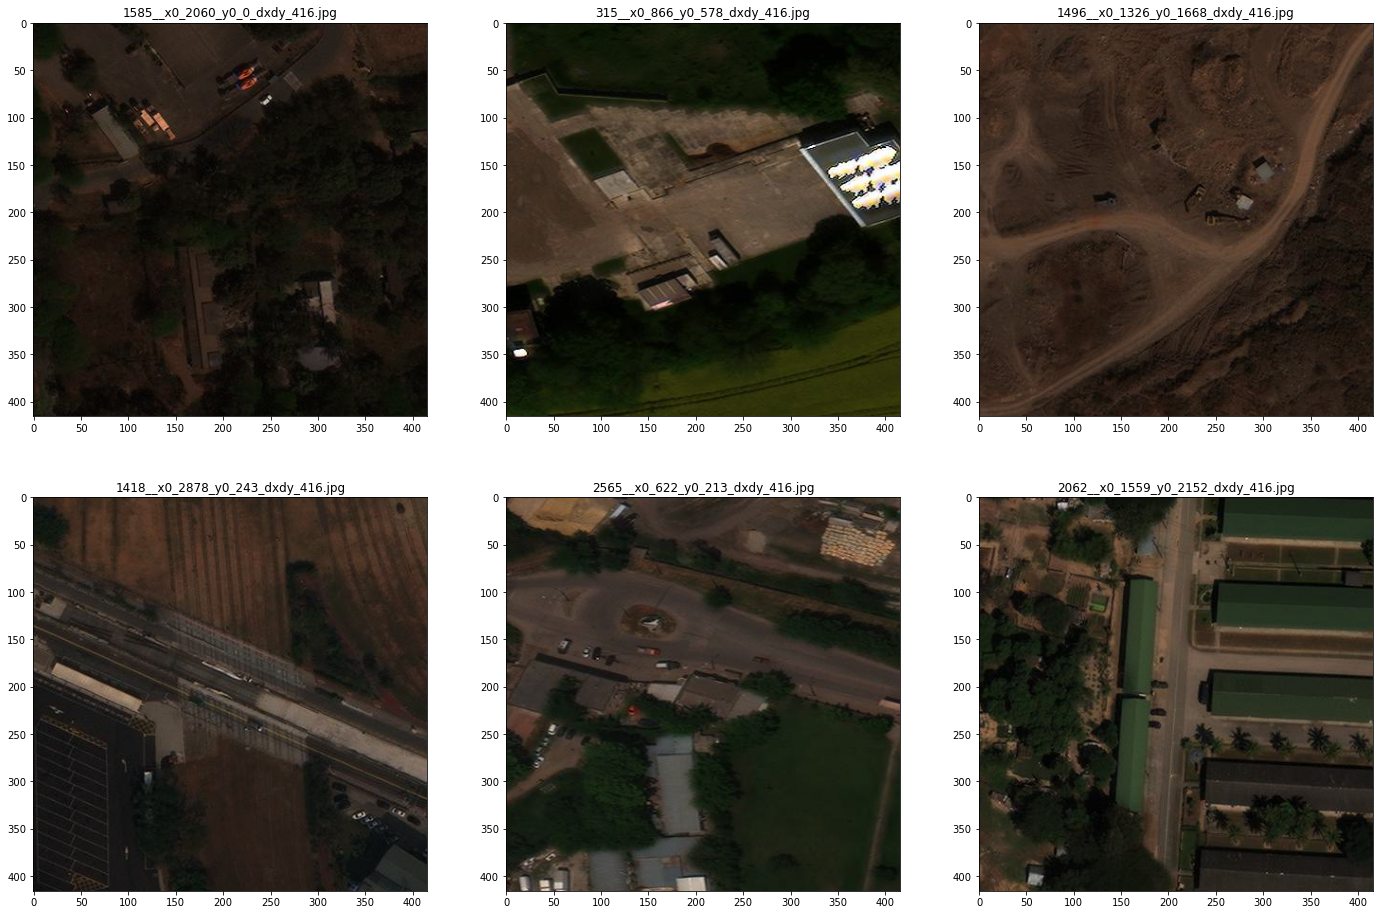

In [9]:
# visualize some of the outputs cutouts
dir_tmp = outdir_ims
rows, cols = 2, 3
figsize = 8
paths_tmp = [os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp) if j.endswith('.jpg')]
rand_selection = random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

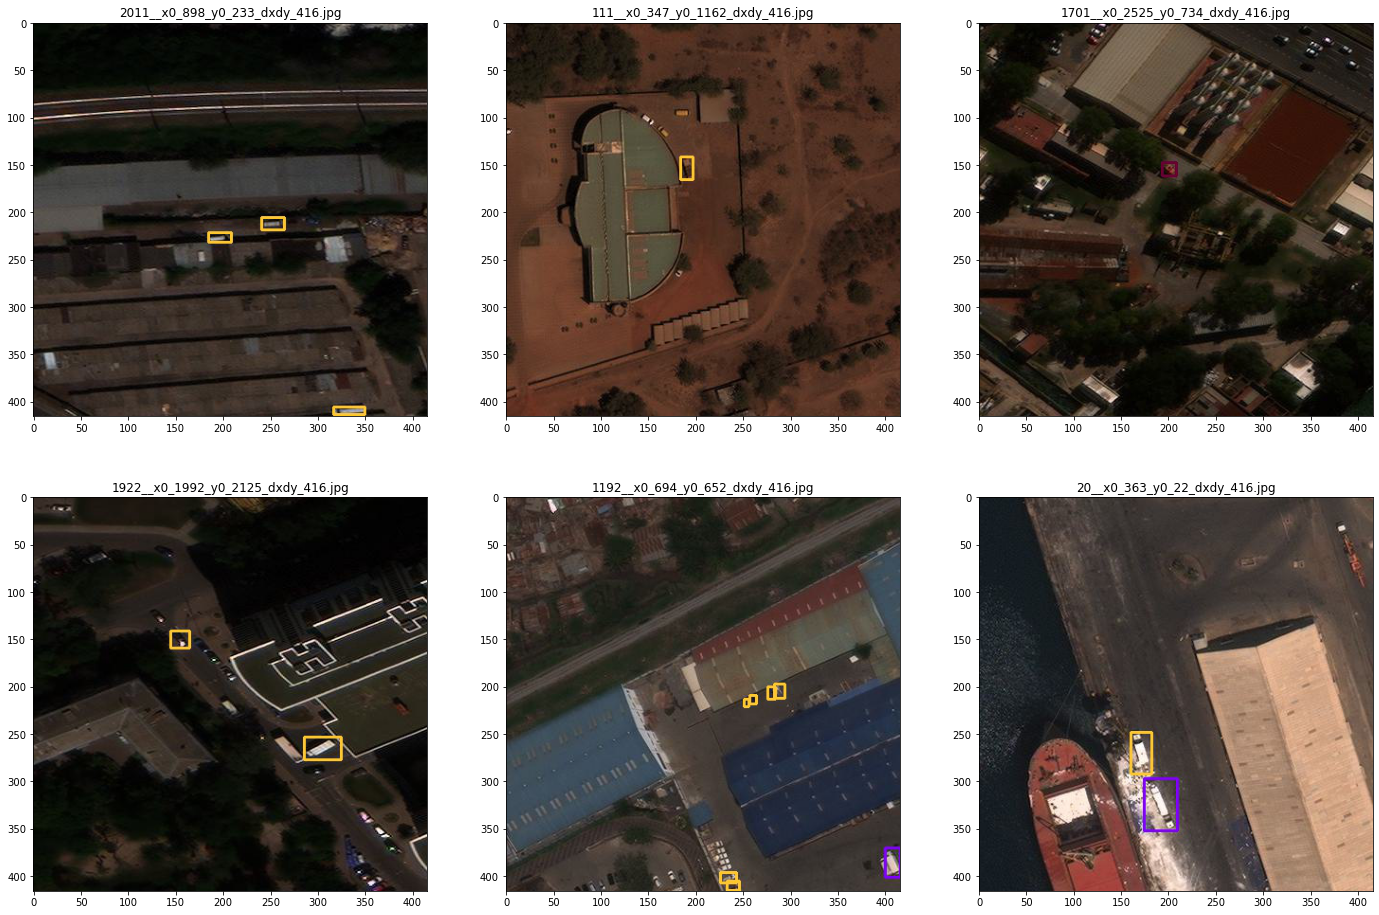

In [10]:
# visualize some of the yolt labels
dir_tmp = outdir_yolt_plots
rows, cols = 2, 3
figsize = 8
paths_tmp = [os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp) if j.endswith('.jpg')]
rand_selection = random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

### 1B. Create text files for training

YOLTv4 requires four text files for training purposes, which we detail below.

In [17]:
# set  paths
pop = 'train'
n_classes = 6
outdir_root = os.path.join(data_root,  pop, 'yoltv4')
txt_dir = os.path.join(outdir_root, 'txt')
os.makedirs(txt_dir) 

names_path = os.path.join(txt_dir, 'xview.name')
train_list_path = os.path.join(txt_dir, 'xview_train_images_list.txt')
valid_list_path = os.path.join(txt_dir, 'xview_valid_images_list.txt')
dot_data_path = os.path.join(txt_dir, 'xview_train.data')

print("names_path:", names_path)
print("train_list_path:", train_list_path)
print("valid_list_path:", valid_list_path)
print("dot_data_path:", dot_data_path)

names_path: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview.name
train_list_path: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview_train_images_list.txt
valid_list_path: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview_valid_images_list.txt
dot_data_path: /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview_train.data


#### .names file:
    
    YOLTv4 requires a .names file with the name of each object.  For example, if we have 30 classes, the rareplanes.name file looks like:
    
        aircraft_type0
        aircraft_type1
        aircraft_type2
        ...
        aircraft_type29 

#### \_list.txt files

    YOLTv4 also requires a txt file listing the training and validation images, which we create below.

In [20]:
valid_iter = 5   # means every 5th item is in valid set

# yolt outputs
outdir_ims = os.path.join(outdir_root, 'images')
outdir_labels = os.path.join(outdir_root, 'labels')

im_list_tot = sorted([os.path.join(outdir_ims, z) for z in os.listdir(outdir_ims) if z.endswith('.jpg')])
# make train and valid_list
im_list_train, im_list_valid = [], []
for i, im_path in enumerate(im_list_tot):
    if (i % valid_iter) == 0:
        im_list_valid.append(im_path)
    else:
        im_list_train.append(im_path)
# print("len im_list_train:", len(im_list_train))
# print("len im_list_valid:", len(im_list_valid))

# create txt files of image paths
for list_tmp, outpath_tmp in [[im_list_train, train_list_path], [im_list_valid, valid_list_path]]:
    df_tmp = pd.DataFrame({'image': list_tmp})
    df_tmp.to_csv(outpath_tmp, header=False, index=False)

# print("outpath_tmp:", outpath_tmp)
# !head {outpath_tmp}

#### .data file

    Create rareplanes.data, according to the command below:

In [24]:
!echo 'classes = ' {n_classes} > {dot_data_path}
!echo 'train = ' {train_list_path} >> {dot_data_path}
!echo 'valid = ' {valid_list_path} >> {dot_data_path}
!echo 'names = ' {names_path} >> {dot_data_path}
!echo 'backup = backup/' >> {dot_data_path}
!cat {dot_data_path}

classes =  6
train =  /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview_train_images_list.txt
valid =  /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview_valid_images_list.txt
names =  /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview.name
backup = backup/


### 1C. Copy labels to training image directory

For YOLTv4, images need to be in the same folder as images for training

In [25]:
pop = 'train'
outdir_root = os.path.join(data_root,  pop, 'yoltv4')
outdir_ims = os.path.join(outdir_root, 'images')
outdir_labels = os.path.join(outdir_root, 'labels')

# copy
for f in os.listdir(outdir_labels):
    if f.endswith('.txt'):
        shutil.copy(os.path.join(outdir_labels, f), outdir_ims)

### 1D. Set up the .cfg file

The data is now prepped, so set up the .cfg file in the _/yoltv4/darknet/cfg_ directory according to your data.  The _yoltv4\_rareplanes.cfg_ file has already been formatted, but for custom data, see instructions [here](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects)):

* Change line max_batches to (classes*2000 but not less than number of training images, but not less than number of training images and not less than 6000), for example max_batches=6000 if you train for 3 classes

* Change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
    
* Set network size width=416 height=416 or any value multiple of 32

* Change line classes=80 to your number of objects in each of 3 [yolo]-layers:

* Change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers. So if classes=1 then should be filters=18. If classes=2 then write filters=21.




___
## 2. Train

With data and cfgs fully prepped, we simply run the following comand on the command line in the yoltv4_gpu0 docker container (see README.md for creating this docker container).

    cd /yoltv4/darknet
	time ./darknet detector train \
        /vol/bitbucket/jrb21/project/xView/data/train/yoltv4/txt/xview_train.data \
        cfg/yolov4-xview.cfg \
        weights/yolov4.conv.137 \
        -dont_show -mjpeg_port 8090 -map


Review progress (plotted at: _/yoltv4/darknet/chart\_yoltv4\_rareplanes.png_), as below:

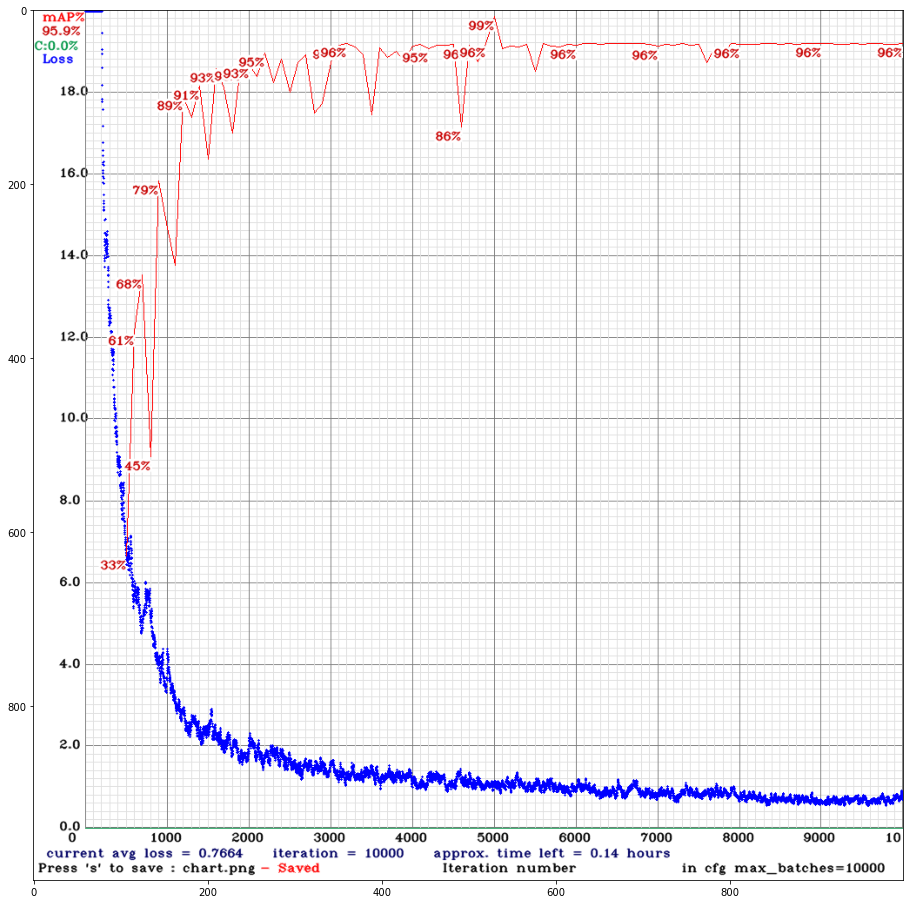

In [36]:
# view progress
chart_path = '/yoltv4/darknet/chart_yoltv4_rareplanes.png'
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(skimage.io.imread(chart_path))

-----
## 3. Prepare Test Data

Follow a similar approach as detailed above for training.

In [ ]:
pop = 'test'
data_root_tmp = os.path.join(data_root, pop)
outdir_root = os.path.join(data_root_tmp, 'yoltv4')
outdir_ims = os.path.join(outdir_root, 'images_slice')
outdir_txt = os.path.join(outdir_root, 'txt')
outpath_test_txt = os.path.join(outdir_txt, 'test.txt')
names_path = os.path.join(outdir_txt, 'rareplanes.name')
# valid_list_path = os.path.join(txt_dir, 'rareplanes_test_images_list.txt')
dot_data_path = os.path.join(outdir_txt, 'rareplanes_test.data')
os.makedirs(outdir_ims, exist_ok=True)
os.makedirs(outdir_txt, exist_ok=True)

sliceHeight, sliceWidth = 416, 416
slice_overlap=0.2
slice_sep = '__'
out_ext = '.jpg'
overwrite = False
verbose = False

im_dir = os.path.join(data_root_tmp, 'images')
im_list = [z for z in os.listdir(im_dir) if z.endswith('.tif')]

#################
# slice images
for i,im_name in enumerate(im_list):
    im_path = os.path.join(im_dir, im_name)
    im_tmp = skimage.io.imread(im_path)
    h, w = im_tmp.shape[:2]
    if verbose:
        print(i, "/", len(im_list), im_name, "h, w =", h, w)

    # tile data
    out_name = im_name.split('.')[0]
    tile_ims_labels.slice_im_plus_boxes(
        im_path, out_name, outdir_ims,
        sliceHeight=sliceHeight, sliceWidth=sliceWidth,
        overlap=slice_overlap, slice_sep=slice_sep,
        skip_highly_overlapped_tiles=False,
        overwrite=overwrite,
        out_ext=out_ext, verbose=verbose)

#################
# make list of test files
im_list_test = []
for f in sorted([z for z in os.listdir(outdir_ims) if z.endswith('.jpg')]):
    im_list_test.append(os.path.join(outdir_ims, f))
df_tmp = pd.DataFrame({'image': im_list_test})
df_tmp.to_csv(outpath_test_txt, header=False, index=False)
# print("N test ims:", len(df_tmp))
# !head {outpath_test_txt}

#################
# create .data file
!echo 'classes = ' {n_classes} > {dot_data_path}
!echo 'train = ' >> {dot_data_path}
!echo 'valid = ' {outpath_test_txt} >> {dot_data_path}
!echo 'names = ' {names_path} >> {dot_data_path}
!echo 'backup = backup/' >> {dot_data_path}

___
## 4. Test

1. Execute on the command line (proceeds at >80 frames per second on a Tesla P100):

        cd /yoltv4/darknet
	    time ./darknet detector valid data/rareplanes_test.data cfg/yoltv4_rareplanes.cfg backup/ yoltv4_rareplanes_best.weights -out rareplanes_preds_v0_

2. Post-process detections:

	A. Move detections into results directory
    
		mkdir /yoltv4/darknet/results/rareplanes_preds_v0
		mkdir  /yoltv4/darknet/results/rareplanes_preds_v0/orig_txt
		mv /yoltv4/darknet/results/rareplanes_preds_v0*  /yoltv4/darknet/results/rareplanes_preds_v0/orig_txt/

    B. Stitch detections back together and make plots
    
		time python /yoltv4/yoltv4/post_process.py \
		    --pred_dir=/yoltv4/darknet/results/rareplanes_preds_v0/orig_txt/ \
		    --raw_im_dir=/local_data/cosmiq/wdata/rareplanes/test/images/ \
		    --sliced_im_dir=/local_data/cosmiq/wdata/rareplanes/test/yoltv4/images_slice/ \
		    --out_dir= /yoltv4/darknet/results/rareplanes_preds_v0 \
		    --detection_thresh=0.25 \
		    --slice_size=416} \
		    --n_plots=8
		 

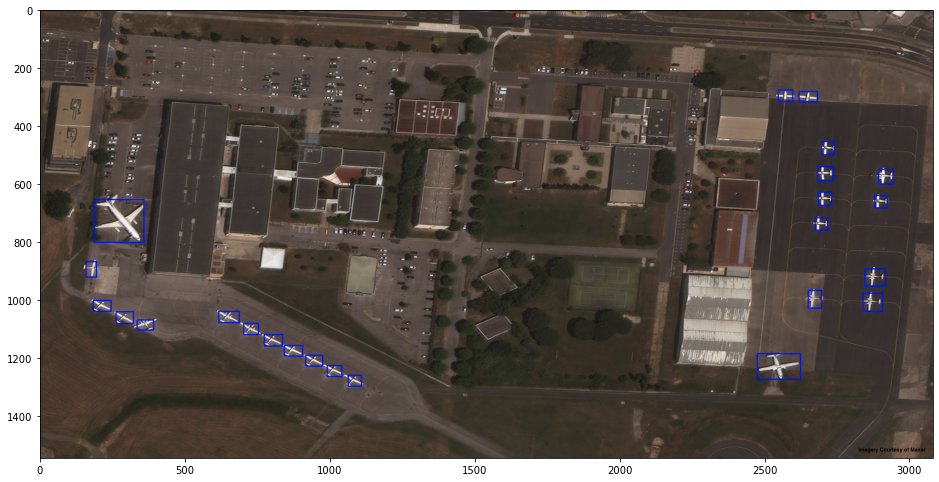

In [41]:
# Outputs will looks something like:
im_path = '/yoltv4/darknet/results/rareplanes_preds_v0/pred_plots/im0.jpg'
fig, ax = plt.subplots(figsize=(16,16))
_ = ax.imshow(skimage.io.imread(im_path))

_____
## 5. Score

Not fully implemented here just yet, but scoring can be accomplished with [Solaris](https://github.com/CosmiQ/solaris/tree/master/solaris/eval).  Within a Solaris docker file, execute the following on the command line:

    import solaris.eval

    gt_polygons_dir = path_to_ground_truth
    proposal_polygons_dir = os.path.join(yoltv4_path, 'darknet/results/rareplanes_preds_v0/geojsons_pix/')

    solaris.eval.vector.mAP_score(proposal_polygons_dir, gt_polygons_dir,
              prediction_cat_attrib="category", gt_cat_attrib='category',
              object_subset=[], threshold=0.5, confidence_attrib="prob",
              file_format="geojson")